In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
import copy
import random
import os
import glob

In [13]:
from ase.io import read
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from pathlib import Path

# Bismuth parameters 
bi_mass = 208.9804
energy_in_ev = 0.004180159285619251 #1 THz = 0.0041 eV
freq_in_thz = 6.3507799295888985 # converts w=sqrt(k/m) in sqrt(THz/(Angstrom^2 * atomic mass unit)) to THz
t_in_ps = 1 / freq_in_thz
x_saddle=0.23589477841686

energies = np.loadtxt("Input_files/toten.dat")
x = np.linspace(-0.5, 0.9, len(energies))
x=x-x_saddle # to shift saddle point to x=0
bi_yinterp = InterpolatedUnivariateSpline(x, np.array(energies) / energy_in_ev, k=5) # energies are converted to THz from eV
neg_bi_yinterp = InterpolatedUnivariateSpline(x, -np.array(energies) / energy_in_ev, k=5) # energies are converted to THz from eV
bi_xmin = minimize(bi_yinterp, [0.0], bounds=[(-0.1-x_saddle, 0.1-x_saddle)]).x
bi_xmin = bi_xmin[0]

bi_xmax = minimize(neg_bi_yinterp, [0.0], bounds=[(-0.1, 0.1)]).x
bi_xmax = bi_xmax[0]

bi_phomega = np.sqrt(bi_yinterp(bi_xmin, nu=2) / bi_mass)
bi_phfreq_in_thz = bi_phomega * freq_in_thz / (2 * np.pi)

print(bi_xmin, bi_phfreq_in_thz)
print("bi_xmax=",bi_xmax)

-0.2368685245784035 3.033783971322573
bi_xmax= -3.0020225651260803e-10


In [14]:
from numpy.linalg import lstsq

# Base directory containing chi_* files
baseDir = "Input_files/chi_files"
all_pos2 = [4, 12, 16, 24, 28, 32, 38, 42, 48, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 68, 73, 80, 88, 96]

# Process CHI data
bi_eps_2eV = [
    row[1] + 1j * row[2]
    for i in all_pos2
    for row in np.loadtxt(f"{baseDir}/chi_{i}.dat", delimiter=" ")
    if 1.90 <= row[0] <= 2.05
]

bi_eps_2eV = np.array(bi_eps_2eV)

# Polynomial Regression Setup
x = x[all_pos2]
y = bi_eps_2eV.real

num = 9
X_poly = np.column_stack([x**i for i in range(0, num, 2)])  # Even powers

# Solve least squares problem
coefficients, _, _, _ = lstsq(X_poly, y, rcond=None)

# Polynomial and its derivative
poly_model = lambda x: sum(c * x**(2 * i) for i, c in enumerate(coefficients))
poly_derivative_func = lambda x: sum((2 * i) * c * x**(2 * i - 1) for i, c in enumerate(coefficients[1:], start=1))


In [15]:
# Network configuration variables
input_size = 1
hidden_size = 10
output_size = 1
n_pop = 100
#n_gen = 51
#select_gen = [0, 50, 75, 100]  # Only plot selected generations

#Time array parameters
steps = 20000
total_time=20
tspan = [0, total_time/t_in_ps]
tfine = np.linspace(*tspan, steps)
t_eval = tfine

In [17]:
class SimpleFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleFNN, self).__init__()
        # Simple feed-forward with one hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad(): 
            self.fc1.weight = nn.Parameter(torch.tensor([
                [2*np.pi*(1+(bi_phfreq_in_thz/2))/freq_in_thz], 
                [2*np.pi*(1-(bi_phfreq_in_thz/2))/freq_in_thz], 
                [2*np.pi*(2+(bi_phfreq_in_thz/2))/freq_in_thz], 
                [2*np.pi*(2-(bi_phfreq_in_thz/2))/freq_in_thz], 
                [2*np.pi*(1.5+(bi_phfreq_in_thz/2))/freq_in_thz],
                [2*np.pi*(1.5-(bi_phfreq_in_thz/2))/freq_in_thz],
                [2*np.pi*(0.5+(bi_phfreq_in_thz/2))/freq_in_thz], 
                [2*np.pi*(0.5-(bi_phfreq_in_thz/2))/freq_in_thz], 
                [2*np.pi*(2.5+(bi_phfreq_in_thz/2))/freq_in_thz], 
                [2*np.pi*(2.5-(bi_phfreq_in_thz/2))/freq_in_thz], 
            ], dtype=torch.float32))

        #nn.init.constant_(self.fc1.weight, init_constant)
        nn.init.normal_(self.fc1.bias, mean=0, std=1)
        nn.init.normal_(self.fc2.weight, mean=0.8, std=1)
        nn.init.constant_(self.fc2.bias, 0)

    
    def forward(self, x):
        x = torch.sin(self.fc1(x))  # Using sinusoidal activation function
        x = self.fc2(x)
        return x
        
    @staticmethod
    def custom_clamp(x, lower_y, upper_y):
        # Clamping function to ensure outputs are within specified bounds
        range_width = upper_y - lower_y
        return ((x - lower_y) % range_width) + lower_y
        
    def get_output(self, time):
        """Get neural network output for a given time input."""
        time_tensor = torch.tensor([[time]], dtype=torch.float32)
        with torch.no_grad():
            return self(time_tensor).item()
            
def mutate(network, mutation_strength=0.2):
    """ Mutates the network by adding Gaussian noise to its weights and biases. """
    with torch.no_grad():
        for name, param in network.named_parameters():
            if 'fc2.bias' in name :
                continue
            noise = torch.randn_like(param) * mutation_strength
            param.add_(noise)

In [18]:
def init_pop(size, input_size, hidden_size, output_size):
    return [SimpleFNN(input_size, hidden_size, output_size) for _ in range(size)]

# Initialize population
pop = init_pop(n_pop, input_size, hidden_size, output_size)

# Simulation time data
time_steps = torch.linspace(*tspan, steps).reshape(-1, 1)  # Simulating over a time span

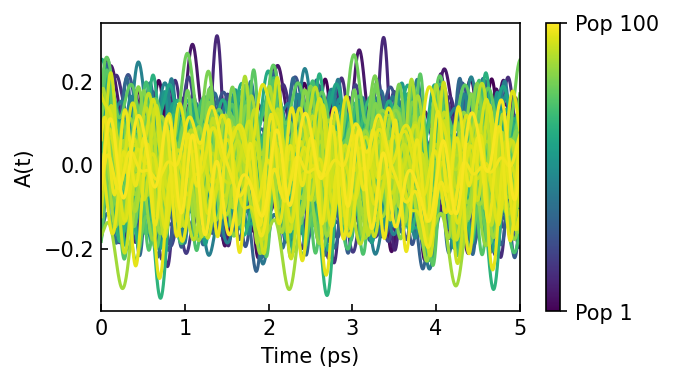

In [19]:
# Plotting the data
from scipy.integrate import simpson

fig, ax = plt.subplots(figsize=(4.5, 2.5), dpi=150, facecolor='white')
norm = Normalize(vmin=1, vmax=n_pop)
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])

# Plot each network's output using a color from the viridis colormap
for i, net in enumerate(pop):
    with torch.no_grad():
        A_t = net(time_steps)
        # Square A(t) to get A(t)^2
        A_t_squared = A_t.squeeze() ** 2  # To ensure A_t is 1D for integration
        A_t_squared_np = A_t_squared.numpy()

        # Perform numerical integration of A(t)^2 over the time domain
        integral_A_t_squared = simpson(y=A_t_squared_np, x=time_steps.numpy().squeeze())  # Assuming t is uniformly spaced
        A_t_norm=A_t.numpy()/np.sqrt(integral_A_t_squared) # Normalized A_t
    ax.plot(tfine*t_in_ps, A_t_norm, label=f'Pop {i+1}', color=viridis(norm(i))) 
    
# Add colorbar
cbar = plt.colorbar(sm, ax=ax, ticks=range(n_pop))
cbar.set_ticks([norm.vmin, norm.vmax])
cbar.ax.set_yticklabels(['Pop 1', f'Pop {n_pop}'])  

ax.set_xlabel('Time (ps)')
ax.set_ylabel('A(t)')
ax.set_xlim(0,5)
ax.tick_params(direction='in')


In [20]:
def score(outputs, target=bi_xmax, scale=1.0): # score based on x at t=t_final----------
    distances = np.sqrt(np.square(np.array(outputs) - target))
    
    # Convert distances to scores using an exponential decay based on the distance
    scores = np.exp(-distances / scale)
    
    return scores.tolist()

def score2(all_v, all_x, target=0.83): # score based on difference in x where v=0----------
    top_3_max_dx_all = []
    scores = []
    for result, x_values in zip(all_v, all_x):
        indices = []
        x_v = []
        for i in range(1, len(result)):
            if (result[i] * result[i - 1]) < 0:
                indices.append(i)
                x_v.append(x_values[i]) 
        
        x_diff = []
        
        for i in range(len(indices) - 1):
            diff = np.linalg.norm(x_v[i] - x_v[i + 1])
            x_diff.append(diff)
            
        # Collect the top 3 maximum differences for the current result
        top_3_max_dx = sorted(x_diff, reverse=True)[:3]
        top_3_max_dx_all.extend(top_3_max_dx)
        
        max_dx = np.max(x_diff)
        #distance = np.linalg.norm(max_dx - target)
        score_value = max_dx/target
        
        scores.append(score_value)
           
    return scores

def score3(all_v, all_x): # score based on difference in avg x within each Tau_v0----------
    #top_3_max_dx_all = []
    scores = []
    tindex = []
    for result, x_values in zip(all_v, all_x):
        indices = []
        time_v0 = []
        time_x0 = []
         #------------------ Calculate times when v=0--------------------------------------- 
        for i in range (1, len(result)):
            if (result[i] * result[i-1]) < 0:
                time_v0.append(tfine[i-1]*t_in_ps)
                indices.append(i-1)
        #------------------ Calculate times when x=0---------------------------------------       
        for i in range (1, len(indices)):     
            min_x=np.min(x_values[indices[i-1]:indices[i]])
            if min_x<0 :
                for j in range(indices[i-1],indices[i]):
                    if (x_values[j-1] < -x_saddle and x_values[j] > -x_saddle) or (x_values[j-1] > -x_saddle and x_values[j] < -x_saddle): 
                        time_x0.append(tfine[j-1]*t_in_ps) 
            elif min_x>0 :
                for j in range(indices[i-1],indices[i]):
                    if (x_values[j-1] < x_saddle and x_values[j] > x_saddle) or (x_values[j-1] > x_saddle and x_values[j] < x_saddle):
                        time_x0.append(tfine[j-1]*t_in_ps)

        #------------------ Calculate Tau_plus, Tau_neg and their ratio---------------------------------------       
        #tau_v0 = [time_v0[i + 2] - time_v0[i] for i in range(1, len(time_x0)-1, 2)]
        #time_points = [time_v0[i] for i in range(1, len(time_v0) - 2, 2)]
        #Tau_plus = [time_x0[i + 1] - time_x0[i] for i in range(1, len(time_x0)-1, 2)]
        #if len(tau_v0) != len(Tau_plus) :            
            #print("lengths of time_v0, time_x0, tau_v0, Tau_plus = ", len(time_v0), len(time_x0), len(tau_v0), len(Tau_plus))               
        #Tau_neg = np.array(tau_v0)-np.array(Tau_plus)
        #ratio=np.array(Tau_plus)/np.array(Tau_neg)    
        
        #------------------ Calculate average x for each Tau-------------------------------
        avg_pos = []
        traj_avg = []
        windows = []
        for i in range(1, len(time_v0) - 2, 2):
            start_index = indices[i]
            end_index = indices[i + 2] 
            windows.append((start_index, end_index))
            
            if end_index < len(x_values):
                sum_pos = sum(x_values[start_index:end_index + 1])
                num_points = end_index - start_index + 1
                if num_points > 0:
                    avg_pos.append(sum_pos / num_points) 
                else:
                    avg_pos.append(0)  
            else:
                avg_pos.append(0)

        for i in range(0, len(avg_pos)):
            if avg_pos[i]<=0:
                frac=1+(avg_pos[i]/x_saddle)
                traj_avg.append(frac)
            elif avg_pos[i]>0:
                frac=1-(avg_pos[i]/x_saddle)
                traj_avg.append(frac)
        
        # Find the maximum fraction value and the corresponding index
        max_value = max(traj_avg)
        max_index = traj_avg.index(max_value)

        max_window_end_index = windows[max_index][1]
        max_time = time_v0[indices.index(max_window_end_index)]
        
        # Convert average positions to score
        scores.append(max_value)
        tindex.append(max_time)

    return scores, tindex
    

In [21]:
import time
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
from scipy.fft import fft, fftfreq
import pickle

start_time = time.time()
num_parent = n_pop//10
pop = init_pop(n_pop, input_size, hidden_size, output_size)

def propagate(t, u, pes_interpolant, epsprime_interpolant, mode_mass, nn_model, nn_norm):
        x, v = u
        dxdt = v
        nn_field = nn_model.get_output(t)
        if np.any(np.isnan(nn_field)) or np.any(np.isinf(nn_field)):
            print(f"Unstable driving force at t={t}: {nn_field}")
        alpha = 8.75    # constant intensity
        driving_force = epsprime_interpolant(x) * (alpha*(nn_field ** 2)/nn_norm)
        # Solve equation of motion
        dvdt = -(pes_interpolant(x, nu=1) + driving_force) / mode_mass - 0.05 * v # damping factor 0.05
        return np.array([dxdt, dvdt])
    
def simulate(nn_model):
    """Simulate the dynamic system for the given model."""
    zero_offset = bi_xmin
    nn_all=[]
    nn_outputs = np.array([nn_model.get_output(t) for t in t_eval])
    nn_outputs_squared = nn_outputs.squeeze()** 2 
    # Perform numerical integration of A(t)^2 over the time domain
    nn_outputs_int = simpson(y=nn_outputs_squared, x=t_eval.squeeze())
    
    sol = solve_ivp(propagate, tspan,[zero_offset + 0.0, 0.0],
                    args=(bi_yinterp, 
                    poly_derivative_func,
                    bi_mass, nn_model, nn_outputs_int),
                    t_eval=tfine,
                    method='Radau',
                    rtol=1e-3,
                    atol=1e-6)
    
    nn_out = np.array([nn_model.get_output(t) for t in t_eval])
    nn_out_norm = (nn_out / np.sqrt(nn_outputs_int))
    return sol, nn_out, nn_out_norm
    
pop_file = []
scores_file = []
num_gen = []
sel_sol_x = []
sel_sol_v = []
sel_At = []

def run_generations(pop, t_eval):
    current_pop = pop
    pop_file.append(current_pop)

    best_scores=[]
    best_score=0
    gen=0
    select_gen = []
    milestones = [0, 0.40, 0.995] # Score milestones
    current_milestone_index = 0

    #for gen in range(n_gen):
    while (best_score <= 0.995):
        print(f"Simulating generation {gen}")
        all_x = []
        all_v = []
        all_times = []
        all_nn_outputs = []
        all_nn_outputs_norm = []
        for nn in current_pop:
            sol, nn_outputs, nn_outputs_norm = simulate(nn)
            all_times.append(sol.t)
            all_x.append(sol.y[0]) 
            all_v.append(sol.y[1])
            all_nn_outputs.append(nn_outputs)
            all_nn_outputs_norm.append(nn_outputs_norm)
        
        ## --------------------------- Score function --------------------------------------------   
        
        #final_outputs = np.array([result[-1] for result in all_v])  # Get the final value of y[0]
        #score_val = score(final_outputs, target=bi_xmax)

        ## --------------------------- Score2 function --------------------------------------------     
        #score_val = score2(all_v, all_x, target=0.83)
        ## -----------------------------------------------------------------------   

        ## --------------------------- Score3 function --------------------------------------------     
        score_val, t_index = score3(all_v, all_x)
        ## -----------------------------------------------------------------------   
        
        sorted_indices = np.argsort(score_val)[::-1]  # Indices of models from best to worst
        rank_positions = np.argsort(sorted_indices) 
        best_score = score_val[sorted_indices[0]]
        print("best score=", best_score)

        scores_file.append(score_val)
        num_gen.append(gen)
        
        if current_milestone_index < len(milestones) and best_score >= milestones[current_milestone_index]:
            select_gen.append(gen)
            current_milestone_index += 1
           
        if gen in select_gen:
            
            for idx in sorted_indices:
 
                if idx in sorted_indices[:3]:

                    if idx in sorted_indices[:1]:
                        sel_sol_x.append(all_x[idx])
                        sel_sol_v.append(all_v[idx])
                    
                    fc1_weights = current_pop[idx].fc1.weight.data.numpy()
                    fc1_bias = current_pop[idx].fc1.bias.data.numpy()
                    fc2_weights = current_pop[idx].fc2.weight.data.numpy() 
                    fc2_bias = current_pop[idx].fc2.bias.data.numpy()
                    np.save(f'FNN-out/L2S_fc1_weights_config_{gen}_{idx}.npy', fc1_weights)
                    np.save(f'FNN-out/L2S_fc1_bias_config_{gen}_{idx}.npy', fc1_bias)
                    np.save(f'FNN-out/L2S_fc2_weights_config_{gen}_{idx}.npy', fc2_weights)
                    np.save(f'FNN-out/L2S_fc2_bias_config_{gen}_{idx}.npy', fc2_bias)

                    if idx in sorted_indices[:1]:
                        sel_At.append(all_nn_outputs[idx])
                      

        # Create new generation: top 10 are carried over, the rest are mutants
        new_pop = [current_pop[idx] for idx in sorted_indices[:num_parent]]  # Top 10 networks
        while len(new_pop) < len(current_pop):
            # Choose a random top network to mutate
            parent_idx = np.random.choice(sorted_indices[:num_parent])
            parent_network = current_pop[parent_idx]
            cloned_network = copy.deepcopy(parent_network)
            mutate(cloned_network)
            new_pop.append(cloned_network)
        
        current_pop = new_pop
        gen +=1
    
    np.savetxt('L2S_out/Continuous/Fig2/Data/scores_2b.dat',scores_file)
    np.savetxt('L2S_out/Continuous/Fig2/Data/gen_2b.dat',num_gen)
    np.savetxt('L2S_out/Continuous/Fig2/Data/sol_x_2c.dat',sel_sol_x)
    np.savetxt('L2S_out/Continuous/Fig2/Data/sol_v_2c.dat',sel_sol_v)
    np.savetxt('L2S_out/Continuous/Fig2/Data/protocol_2d.dat',sel_At) 
    with open('L2S_out/Continuous/Fig2/Data/pop_continuous_fig2.dat', 'wb') as f:
        pickle.dump(pop_file, f)
    
vert_offset = np.linspace(0, 2*n_pop, n_pop)

run_generations(pop, t_eval)

end_time = time.time()
runtime = end_time - start_time
print(f"Runtime of the code block: {runtime:.2f} seconds")
    

Simulating generation 0
best score= 0.10664436521603582
Simulating generation 1
best score= 0.12700479405714293
Simulating generation 2
best score= 0.13194145034315174
Simulating generation 3
best score= 0.13194145034315174
Simulating generation 4
best score= 0.15234368400427045
Simulating generation 5
best score= 0.16036897474729905
Simulating generation 6
best score= 0.16036897474729905
Simulating generation 7
best score= 0.16036897474729905
Simulating generation 8
best score= 0.16036897474729905
Simulating generation 9
best score= 0.16481498430859498
Simulating generation 10
best score= 0.16481498430859498
Simulating generation 11
best score= 0.1694396335410333
Simulating generation 12
best score= 0.1694396335410333
Simulating generation 13
best score= 0.1694396335410333
Simulating generation 14
best score= 0.17449685996200226
Simulating generation 15
best score= 0.17449685996200226
Simulating generation 16
best score= 0.17449685996200226
Simulating generation 17
best score= 0.21155

(36, 100) (36,)


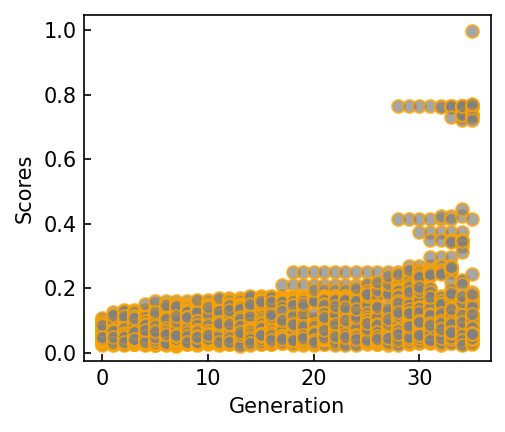

In [23]:
# Similar to Fig 2b---- Scores vs generation--- different run
from matplotlib import cm
from matplotlib.colors import Normalize

scores = np.loadtxt('L2S_out/Continuous/Fig2/Data/scores_2b.dat')
gen_no = np.loadtxt('L2S_out/Continuous/Fig2/Data/gen_2b.dat')

print(scores.shape, gen_no.shape)

fig2b, ax2 = plt.subplots(figsize=(3.5, 3), dpi=150, facecolor='white')
cmap = cm.viridis_r

# Scatter plot with colormap based on rank
for i in range(gen_no.shape[0]):
    ranks = np.argsort(np.argsort(scores[i, :]))
    norm = Normalize(vmin=ranks.min(), vmax=ranks.max())
    colors_score = cmap(norm(ranks))

    ax2.scatter([gen_no[i]] * n_pop, scores[i], alpha=0.7, edgecolor='orange', color='grey', s=38)
    
ax2.set_xlabel('Generation')
ax2.set_ylabel('Scores')
ax2.tick_params(direction='in')

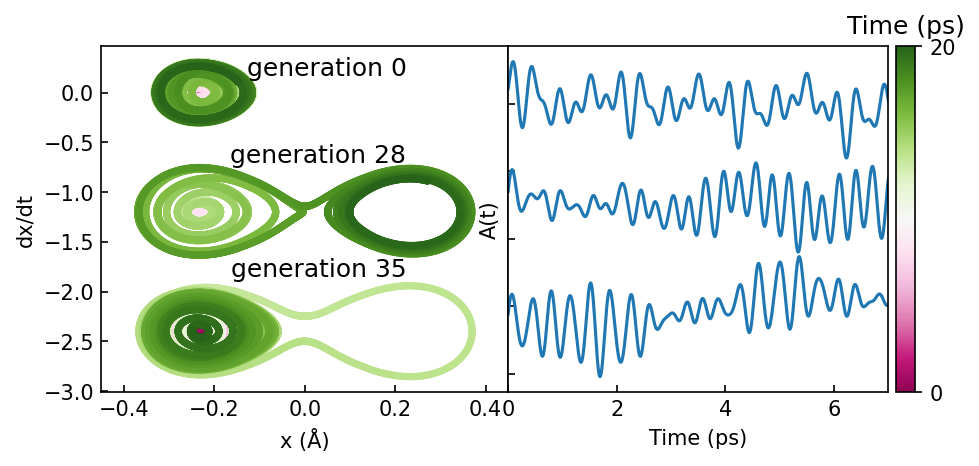

In [26]:
# Fig 2cd---- Phase space + Protocols
from mpl_toolkits.axes_grid1 import make_axes_locatable

sol_x_all = np.loadtxt('L2S_out/Continuous/Fig2/Data/sol_x_2c.dat')
sol_v_all = np.loadtxt('L2S_out/Continuous/Fig2/Data/sol_v_2c.dat')
At_all = np.loadtxt('L2S_out/Continuous/Fig2/Data/protocol_2d.dat')

norm2 = Normalize(vmin=np.min(tfine*t_in_ps), vmax=np.max(tfine*t_in_ps))

fig2cd, (ax3,ax4) = plt.subplots(1,2, figsize=(7, 3), dpi=150, facecolor='white')

for idx in range(len(sol_x_all)-1,-1,-1):
    sc=ax3.scatter(sol_x_all[idx], sol_v_all[idx]-1.2*idx, c = tfine*t_in_ps, cmap='PiYG', edgecolor='none', norm=norm2, s=12)
    ax4.plot(tfine*t_in_ps, At_all[idx]-(15*idx), color='C0', label=f'gen {idx+1}')

ax3.set_xlabel('x (Å)')
ax3.set_ylabel('dx/dt')
ax3.tick_params(direction='in')
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.set_position([0.8, 0.2, 0.03, 0.6])
cbar = fig2cd.colorbar(sc, cax=cax,orientation='vertical')
cbar.ax.set_title('Time (ps)')
cbar.set_ticks([norm2.vmin, norm2.vmax])
cbar.ax.set_yticklabels(['0', '20'])
ax4.set_xlabel('Time (ps)')
ax4.set_ylabel('A(t)', labelpad=0.5)
ax4.set_xlim(0,7)
ax4.tick_params(direction='in')
ax3.text(0.75, 0.97, "generation 0", transform=ax3.transAxes,fontsize=12, va='top', ha='right')
ax3.text(0.75, 0.72, "generation 28", transform=ax3.transAxes,fontsize=12, va='top', ha='right')
ax3.text(0.75, 0.39, "generation 35", transform=ax3.transAxes,fontsize=12, va='top', ha='right')
ax4.set_yticklabels([])

# Remove the last x-axis tick label for ax3
xticks = ax3.get_xticks()
xticklabels = [item.get_text() for item in ax3.get_xticklabels()]
if xticklabels:
    xticklabels[-1] = ''
ax3.set_xticks(xticks)
ax3.set_xticklabels(xticklabels)
ax3.set_xlim(-0.45,0.45)

plt.subplots_adjust(wspace=0)